In [1]:
!mkdir ./data/
!wget https://www.andrew.cmu.edu/user/dvaroday/14757/data/hw5/data.zip
!mv data.zip ./data
!unzip ./data/data.zip -d ./data

--2024-11-18 01:34:57--  https://www.andrew.cmu.edu/user/dvaroday/14757/data/hw5/data.zip
Resolving www.andrew.cmu.edu (www.andrew.cmu.edu)... 128.2.42.53
Connecting to www.andrew.cmu.edu (www.andrew.cmu.edu)|128.2.42.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1204890 (1.1M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.15M   320KB/s    in 3.7s    

2024-11-18 01:35:01 (320 KB/s) - ‘data.zip’ saved [1204890/1204890]

Archive:  ./data/data.zip
  inflating: ./data/Brush_teeth/Accelerometer-2011-04-11-13-28-18-brush_teeth-f1.txt  
  inflating: ./data/Brush_teeth/Accelerometer-2011-04-11-13-29-54-brush_teeth-f1.txt  
  inflating: ./data/Brush_teeth/Accelerometer-2011-05-30-08-35-11-brush_teeth-f1.txt  
  inflating: ./data/Brush_teeth/Accelerometer-2011-05-30-09-36-50-brush_teeth-f1.txt  
  inflating: ./data/Brush_teeth/Accelerometer-2011-05-30-10-34-16-brush_teeth-m1.txt  
  inflating: ./data/Brush_teeth/Accele

In [2]:
import os

path = '/content/data/'

folders = sorted(os.listdir(path))[:-1]
print(folders)

['Brush_teeth', 'Climb_stairs', 'Comb_hair', 'Descend_stairs', 'Drink_glass', 'Eat_meat', 'Eat_soup', 'Getup_bed', 'Liedown_bed', 'Pour_water', 'Sitdown_chair', 'Standup_chair', 'Use_telephone', 'Walk']


### Build

In [3]:
# IMPORTING LIBRARIES
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix

In [19]:
# SPLITTING DATA
#ingesting the txt files and creating one DF
def get_dataframe(folders):
  df_list = []
  #iterating through the folders
  for folder in folders:
    files = os.listdir(f'/content/data/{folder}')
    for file in files:
        #creating df per activity based on each file
        df = pd.read_csv(f'/content/data/{folder}/{file}', sep=" ", header=None)
        #creating column 'label' for dataframe and assigned the folder name as values
        df['label'] = folder
        #appending the dataframe for each activity to a list
        df_list.append(df)
  #concatinating all the dfs to create on big dataframe
  combined_df = pd.concat(df_list, ignore_index=True)
  return combined_df

#calling the function to create the large dataframe
final_df = get_dataframe(folders)

#separating the DF based on the activity labels
def div_by_activities(df):
  #creating list of unique labels from label column
  columns = df["label"].unique()
  dfs = []
  for col in columns:
    #separating the dataframes based on the labels
    filtered_df = df[df['label'] == col]
    #adding all the separate dfs to list
    dfs.append(filtered_df)
  return dfs
#calling the function to separate the df
df_by_act = div_by_activities(final_df)

#preparing traing and testing data for each activity
def split_data(list_df, train_pct, test_pct):
  train_set = []
  test_set = []
  #iterting through the list of dfs that are separated based on its activities
  for df in list_df:
    #for each acitivity df, shuffling is performed
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    #https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows

    #selecting the training and testing data set from each activity dataframe
    train = df_shuffled.iloc[:int(len(df)*train_pct), :]
    test = df_shuffled.iloc[int(len(df)*(1-test_pct)):, :]

    #appending each extracted data set to a list
    train_set.append(train)
    test_set.append(test)
  return train_set, test_set

training, testing = split_data(df_by_act, 0.8, 0.2)

In [20]:
# EXTRACTING SEGMENTS FROM ALL ACCELEROMETER TRACES
#creating segments for each activity for training and testing
def get_segments(listed_activities, segment_length):
  segments = []
  labels = []
  columns = final_df["label"].unique()
  #looping over each train and test dataframes for each activities
  for idx in range(len(listed_activities)):
    #generating indexes to slice through the datasets based on given segment length
    for i in range(0, len(listed_activities[idx])-segment_length, segment_length):
      #for each activity dataframe, slice with a length of given segment is taken without the labels column
      slicing = listed_activities[idx].iloc[i:(i+segment_length), :-1].values
      #converting 3D data to 1D data
      flat_slice = slicing.flatten()
      #appending each slice to the segments list
      segments.append(flat_slice)
      #appending each corresponding encoded label to labels list
      labels.append(idx)

  return segments, labels

segmented_train_features, segmented_train_labels = get_segments(training, 32)
segmented_test_features, segmented_test_labels = get_segments(testing, 32)

In [21]:
# CLUSTERING
#defining kmeans function fot both testing and training set
def kmeans_clustering(train_data, test_data, k):
    # initilize k means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    # fit the train data
    kmeans.fit(train_data)
    # clustering data for train and test sets
    clustered_train = kmeans.labels_
    clustered_test = kmeans.predict(test_data)
    return clustered_train, clustered_test

assigned_clusters_train, assigned_clusters_test = kmeans_clustering(segmented_train_features, segmented_test_features, 50)


In [22]:
# FEATURIZING BY BUILDING HISTOGRAMS (OR COUNT VECTORS)
#taking in the list of cluster assigned values and creating histogram
def get_histogram(assigned_clusters, k):
    histograms = []
    for cluster in assigned_clusters:
        #creating histogram for each cluster
        hist, bins = np.histogram(cluster, bins=np.arange(k + 1))
        #https://www.geeksforgeeks.org/numpy-histogram-method-in-python/

        #appending the created historgram to list
        histograms.append(hist)
        #making sure it is np array before passing it to ML model
    return np.array(histograms)

train_x = get_histogram(assigned_clusters_train, 50)
test_x = get_histogram(assigned_clusters_test, 50)

In [23]:
# CLASSIFICATION AND EVALUATION

def train(x_train, label_train, x_test, label_test):
  #making sure it is np array before passing it to ML model
  label_train = np.array(label_train)
  label_test = np.array(label_test)
  #initializing the random forest
  random_forest = RandomForestClassifier(n_estimators=200, random_state=42)
  #training on random forest classifier
  random_forest.fit(x_train, label_train)
  #predicting labels
  predictions_on_testset = random_forest.predict(x_test)
  predictions_on_trainset = random_forest.predict(x_train)
  #calculating accuracies
  accuracy_test = accuracy_score(label_test, predictions_on_testset)
  accuracy_train = accuracy_score(label_train, predictions_on_trainset)

  return accuracy_test, accuracy_train

result_test, result_train = train(train_x, segmented_train_labels, test_x, segmented_test_labels)
# train accuracy without any tuning
print(f" Train accuracy: {result_train}")

 Train accuracy: 0.7468399820708203


### Optimize

In [25]:
#building parameter grid search
segment_length = [8, 16, 32, 40, 60, 128, 200, 256, 400, 512, 1024]
k = [15, 25, 50, 100, 200, 300]
best_so_far = float('-inf')
best_parameters = {}
#iterating through the parameters to find the best accuracy on the test set.
for k_value, segment_length_value in itertools.product(k, segment_length):
  segmented_train_features, segmented_train_labels = get_segments(training, segment_length_value)
  segmented_test_features, segmented_test_labels = get_segments(testing, segment_length_value)

  assigned_clusters_train, assigned_clusters_test = kmeans_clustering(segmented_train_features, segmented_test_features, k_value)


  train_x = get_histogram(assigned_clusters_train, k_value)
  test_x = get_histogram(assigned_clusters_test, k_value)
  result_test, result_train = train(train_x, segmented_train_labels, test_x, segmented_test_labels)

  print(f"for k = {k_value} and segment length = {segment_length_value} test accuracy: {result_test}")
  #updating the best so far parameters.
  if result_test > best_so_far:
    best_so_far = result_test
    print("This is the best accuracy so far...\n")
    best_parameters["k"] = k_value
    best_parameters["segment_length"] = segment_length_value


print(f"The best parameters, k : {best_parameters['k']}, segment length : {best_parameters['segment_length']}")

for k = 15 and segment length = 8 test accuracy: 0.48027967013266404
This is the best accuracy so far...

for k = 15 and segment length = 16 test accuracy: 0.501973448152135
This is the best accuracy so far...

for k = 15 and segment length = 32 test accuracy: 0.7385057471264368
This is the best accuracy so far...

for k = 15 and segment length = 40 test accuracy: 0.6678635547576302
for k = 15 and segment length = 60 test accuracy: 0.738191632928475
for k = 15 and segment length = 128 test accuracy: 0.763768115942029
This is the best accuracy so far...

for k = 15 and segment length = 200 test accuracy: 0.725
for k = 15 and segment length = 256 test accuracy: 0.7456140350877193
for k = 15 and segment length = 400 test accuracy: 0.6790697674418604
for k = 15 and segment length = 512 test accuracy: 0.6526946107784432
for k = 15 and segment length = 1024 test accuracy: 0.55
for k = 25 and segment length = 8 test accuracy: 0.510129078522768
for k = 25 and segment length = 16 test accuracy:

### Evaluate

Testing Accuracy after hyper tuning: 0.8782608695652174 

[[ 46   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  23   0  12   0   0   0   0   0   0   0   0   0  27]
 [  0   0  36   0   0   0   0   0   0   0   0   0   0   0]
 [  0   3   0  21   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  66   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  48   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  10   0   0   0   0]
 [  0   0   0   0   0   0   0  70   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0  13   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0   0  65   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  39   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   2  36   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  23   0]
 [  0  11   0   0   0   0   0   0   0   0   0   0   0 133]]


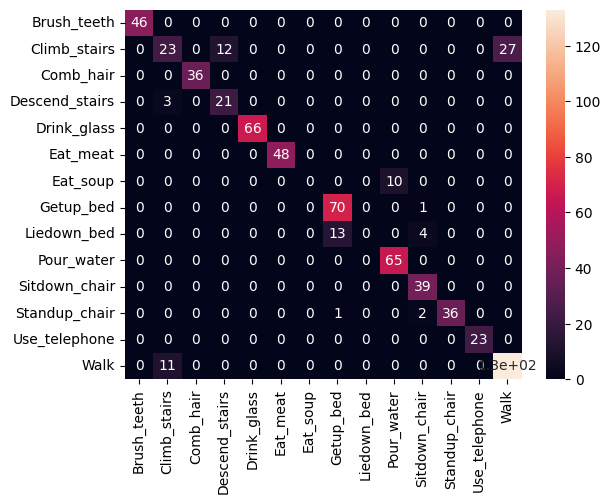

In [26]:
#printing out the accuracy and confusion matrix based on best parameters

#segment length = 128
#k cluster = 25
final_df = get_dataframe(folders)
df_by_act = div_by_activities(final_df)
training, testing = split_data(df_by_act, 0.8, 0.2)

segmented_train_features, segmented_train_labels = get_segments(training, 128)
segmented_test_features, segmented_test_labels = get_segments(testing, 128)

assigned_clusters_train, assigned_clusters_test = kmeans_clustering(segmented_train_features, segmented_test_features, 25)


train_x = get_histogram(assigned_clusters_train, 25)
test_x = get_histogram(assigned_clusters_test, 25)

label_train = np.array(segmented_train_labels)
label_test = np.array(segmented_test_labels)

#initializing the random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
#training on random forest classifier
random_forest.fit(train_x, label_train)
#predicting labels
predictions_on_testset = random_forest.predict(test_x)
#calculating accuracies
accuracy_test = accuracy_score(label_test, predictions_on_testset)

#building confusion matrix
matrix = confusion_matrix(label_test, predictions_on_testset)

#finding the labels
columns = final_df["label"].unique()

sns.heatmap(matrix, annot=True, xticklabels = columns, yticklabels = columns)
#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
print(f"Testing Accuracy after hyper tuning:", accuracy_test, "\n")
print(matrix)